## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix
#print('hej')

2.2.0
C:\Users\PC\AppData\Local\Temp\tmp4cmgtt25\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


# reading in the market data (done automatically atm)

In [3]:
file

'8'

In [4]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [5]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [6]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

### Dropping ETFS and market indices

In [7]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [8]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [9]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [10]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [11]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [12]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [13]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
# #                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                       'macd_diff',
#                                                       'macd_signal',
#                                                     'dis5',
#                                                     'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 5
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,
                                                 ticker_dummies=False)

C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


AAPL done
ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
INTC done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done


## Splitting the data

## Adding ticker dummies

In [14]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

In [15]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0',
       ...
       'd_ticker_SO', 'd_ticker_SRE', 'd_ticker_T', 'd_ticker_TM',
       'd_ticker_TSLA', 'd_ticker_TSM', 'd_ticker_UNP', 'd_ticker_UPS',
       'd_ticker_V', 'd_ticker_WMT'],
      dtype='object', length=126)

## Constructing our final train/validation sets

In [16]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

test_index = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].index
test_index = tempIndices.loc[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(343200, 126)
(343200, 1)
(85690, 126)
(85690, 1)


In [17]:
X_train

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.750,0.310,-0.750,81.760,0.24,1.06,0.07,0.80,14.0,20.0,...,0,0,0,0,0,0,0,0,0,0
2,-0.030,0.160,-0.320,91.220,0.18,0.58,0.05,0.12,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,0.105,0.105,-0.100,82.370,0.13,0.54,0.10,0.26,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.335,0.685,-0.380,233.540,2.39,3.99,1.42,2.10,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343195,0.035,0.165,-0.040,51.300,0.17,0.26,0.01,0.02,5.0,23.0,...,0,0,0,0,0,1,0,0,0,0
343196,0.890,0.965,-0.290,169.435,0.35,1.41,0.01,0.93,1.0,10.0,...,0,0,0,0,0,0,1,0,0,0
343197,0.105,0.235,-0.465,97.955,0.86,1.32,0.06,0.15,1.0,6.0,...,0,0,0,0,0,0,0,1,0,0
343198,-0.080,0.540,-0.245,195.705,0.75,1.08,0.01,0.07,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [19]:
{i:colname for i,colname in enumerate(X_train.columns)}

{0: 'open_lag0',
 1: 'high_lag0',
 2: 'low_lag0',
 3: 'close_lag0',
 4: 'spread_open_lag0',
 5: 'spread_high_lag0',
 6: 'spread_low_lag0',
 7: 'spread_close_lag0',
 8: 'bidsize_open_lag0',
 9: 'bidsize_high_lag0',
 10: 'bidsize_low_lag0',
 11: 'bidsize_close_lag0',
 12: 'ofrsize_open_lag0',
 13: 'ofrsize_high_lag0',
 14: 'ofrsize_low_lag0',
 15: 'ofrsize_close_lag0',
 16: 'relReturns_DIA_lag0',
 17: 'relReturns_IDU_lag0',
 18: 'relReturns_IYC_lag0',
 19: 'relReturns_IYE_lag0',
 20: 'relReturns_IYG_lag0',
 21: 'relReturns_IYH_lag0',
 22: 'relReturns_IYJ_lag0',
 23: 'relReturns_IYK_lag0',
 24: 'relReturns_IYM_lag0',
 25: 'relReturns_IYR_lag0',
 26: 'relReturns_IYW_lag0',
 27: 'relReturns_IYZ_lag0',
 28: 'relReturns_QQQ_lag0',
 29: 'relReturns_SPY_lag0',
 30: 'open_lag1',
 31: 'high_lag1',
 32: 'low_lag1',
 33: 'close_lag1',
 34: 'spread_open_lag1',
 35: 'spread_high_lag1',
 36: 'spread_low_lag1',
 37: 'spread_close_lag1',
 38: 'bidsize_open_lag1',
 39: 'bidsize_high_lag1',
 40: 'bidsize_

In [20]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

In [21]:
X_train.iloc[:,0].mean(),X_train.iloc[:,0].std()

(6.059080975878666e-16, 1.000001456879563)

In [22]:
X_test.iloc[:,0].mean(),X_test.iloc[:,0].std()

(-0.00026143140617190656, 0.918681214317273)

## Prepping for models

In [23]:
N_VALIDATION = y_test.shape[0] #int(1e3)
N_TRAIN = y_train.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 50

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X_train.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343200, 85690, 428890, 1340, 1311, 67000)

In [24]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([16954, 17323, 17371, 17050, 16992], dtype=int64))

In [25]:
y_test

,0
0,0.0
1,4.0
2,0.0
3,0.0
4,0.0
...,...
85685,0.0
85686,0.0
85687,0.0
85688,0.0


## A Logistic Regression model in TF/Keras

In [26]:
one_hot = True
# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

if one_hot:
    y_train_1h = one_hot_encode(y_train.values.astype(np.int), n_classes)
    y_test_1h = one_hot_encode(y_test.values.astype(np.int), n_classes)

In [27]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(5,
                       input_shape=(FEATURES,),
                       activation='softmax',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),#'categorical_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping
             #tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            X_train, #train_features,
                            y_train_1h, #y_train, #train_labels,
                            batch_size=3300, #BATCH_SIZE,
                            epochs=50, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(X_test, y_test_1h),
                            verbose=0) #(val_features, val_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 635       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.7961,  auc:0.4873,  loss:6.3723,  val_accuracy:0.7991,  val_auc:0.4931,  val_loss:3.4033,  
..................................................

In [28]:
model.evaluate(X_test,  y_test_1h, verbose=2)

2678/2678 - 7s - loss: 1.6029 - accuracy: 0.8001 - auc: 0.5531


[1.602911353111267, 0.8000516295433044, 0.5530951023101807]

In [29]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [30]:
# import datetime
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# %tensorboard --logdir logs

In [49]:
probs= model.predict(X_test, verbose=1)
probs

2678/2678 [==============================] - 6s 2ms/step


array([[0.14930744, 0.18085897, 0.19931148, 0.1965635 , 0.27395856],
       [0.1349622 , 0.18114185, 0.19793497, 0.20101458, 0.2849464 ],
       [0.15769388, 0.18944031, 0.19877464, 0.20093921, 0.253152  ],
       ...,
       [0.191785  , 0.2032637 , 0.19480327, 0.20361024, 0.20653778],
       [0.20051968, 0.20487507, 0.19325662, 0.20431341, 0.19703513],
       [0.19093095, 0.20127472, 0.19565451, 0.1965479 , 0.21559194]],
      dtype=float32)

In [53]:
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [54]:
X_test.set_index(pd.MultiIndex.from_frame(test_index), inplace=True)
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [55]:
test_index

,days,timestamps,ticker
6240,20200526,0,AAPL
14038,20200526,0,ABBV
21836,20200526,0,ABT
29634,20200526,0,AEP
37432,20200526,0,AMT
...,...,...,...
397697,20200529,387,TSM
405495,20200529,387,UNP
413293,20200529,387,UPS
421091,20200529,387,V


In [56]:
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [57]:
preds = pd.DataFrame(model.predict(X_test, verbose=1))
preds
# preds[0] = 1 - preds[1]

2678/2678 [==============================] - 6s 2ms/step


,0,1,2,3,4
0,0.149307,0.180859,0.199311,0.196563,0.273959
1,0.134962,0.181142,0.197935,0.201015,0.284946
2,0.157694,0.189440,0.198775,0.200939,0.253152
3,0.150798,0.183481,0.196295,0.207292,0.262134
4,0.203026,0.180519,0.187863,0.181676,0.246917
...,...,...,...,...,...
85685,0.185940,0.199895,0.199386,0.198297,0.216482
85686,0.197642,0.204956,0.194180,0.205177,0.198045
85687,0.191785,0.203264,0.194803,0.203610,0.206538
85688,0.200520,0.204875,0.193257,0.204313,0.197035


In [58]:
#preds = preds[[0,1]]
preds

,0,1,2,3,4
0,0.149307,0.180859,0.199311,0.196563,0.273959
1,0.134962,0.181142,0.197935,0.201015,0.284946
2,0.157694,0.189440,0.198775,0.200939,0.253152
3,0.150798,0.183481,0.196295,0.207292,0.262134
4,0.203026,0.180519,0.187863,0.181676,0.246917
...,...,...,...,...,...
85685,0.185940,0.199895,0.199386,0.198297,0.216482
85686,0.197642,0.204956,0.194180,0.205177,0.198045
85687,0.191785,0.203264,0.194803,0.203610,0.206538
85688,0.200520,0.204875,0.193257,0.204313,0.197035


In [59]:
# np.random.seed(2020)
# rand_numbers = np.random.rand(85690,3)
# preds = rand_numbers / rand_numbers.sum(axis=1).reshape(-1,1)
# preds = pd.DataFrame(preds)
# preds

In [60]:
preds['class'] = preds.values.argmax(axis=1)
preds

,0,1,2,3,4,class
0,0.149307,0.180859,0.199311,0.196563,0.273959,4
1,0.134962,0.181142,0.197935,0.201015,0.284946,4
2,0.157694,0.189440,0.198775,0.200939,0.253152,4
3,0.150798,0.183481,0.196295,0.207292,0.262134,4
4,0.203026,0.180519,0.187863,0.181676,0.246917,4
...,...,...,...,...,...,...
85685,0.185940,0.199895,0.199386,0.198297,0.216482,4
85686,0.197642,0.204956,0.194180,0.205177,0.198045,3
85687,0.191785,0.203264,0.194803,0.203610,0.206538,4
85688,0.200520,0.204875,0.193257,0.204313,0.197035,1


In [61]:
np.unique(preds['class'], return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([12061, 37199,  6630,  7679, 22121], dtype=int64))

In [62]:
preds = preds.set_index(X_test.index) #.loc[(20200526,0)]
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.149307  0.180859  0.199311  0.196563  0.273959   
                    ABBV    0.134962  0.181142  0.197935  0.201015  0.284946   
                    ABT     0.157694  0.189440  0.198775  0.200939  0.253152   
                    AEP     0.150798  0.183481  0.196295  0.207292  0.262134   
                    AMT     0.203026  0.180519  0.187863  0.181676  0.246917   
...                              ...       ...       ...       ...       ...   
20200529 387        TSM     0.185940  0.199895  0.199386  0.198297  0.216482   
                    UNP     0.197642  0.204956  0.194180  0.205177  0.198045   
                    UPS     0.191785  0.203264  0.194803  0.203610  0.206538   
                    V       0.200520  0.204875  0.193257  0.204313  0.197035   
                    WMT     0.190931  0.201275  0.195655  0.196548  0.215592   

                            class  
days     timestamps ticker         
20200526 0          AAPL        4  
                    ABBV        4  
                    ABT         4  
                    AEP         4  
                    AMT         4  
...                           ...  
20200529 387        TSM         4  
                    UNP         3  
                    UPS         4  
                    V           1  
                    WMT         4  

[85690 rows x 6 columns]

In [66]:
temp = preds.loc[20200526,0]

In [73]:
temp

,0,1,2,3,4,class
ticker,,,,,,
AAPL,0.149307,0.180859,0.199311,0.196563,0.273959,4
ABBV,0.134962,0.181142,0.197935,0.201015,0.284946,4
ABT,0.157694,0.189440,0.198775,0.200939,0.253152,4
AEP,0.150798,0.183481,0.196295,0.207292,0.262134,4
AMT,0.203026,0.180519,0.187863,0.181676,0.246917,4
APD,0.230459,0.156845,0.180871,0.167188,0.264637,4
BA,0.370838,0.215371,0.163755,0.160604,0.089431,0
BABA,0.222037,0.199479,0.202491,0.181584,0.194409,0
BAC,0.356586,0.208793,0.182177,0.164402,0.088042,0


In [74]:
temp[temp['class'] == 4][[4,'class']]

,4,class
ticker,,
AAPL,0.273959,4
ABBV,0.284946,4
ABT,0.253152,4
AEP,0.262134,4
AMT,0.246917,4
APD,0.264637,4
BP,0.227293,4
CHL,0.239071,4
COST,0.272795,4


In [76]:
temp[temp['class'] == 1][0]

ticker
LFC    0.206862
Name: 0, dtype: float32

In [113]:
probs = pd.DataFrame(columns=['ticker','prob','class'])
## Adding class 0
probs[['ticker','prob','class']] = temp[temp['class'] == 0][[0,'class']].reset_index().copy(deep=True)
# ## Adding class 4
probs = pd.concat([probs,temp[temp['class'] == 4][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})],
                  axis=0)

# ## Adding other classes - NB: We have randomly selected the probs from columns 4 - we would have chosen any of the columns.
# probs = pd.concat([probs,temp[(temp['class'] != 0)|(temp['class'] != 4)][[4,'class']].reset_index().copy(deep=True)])
probs = pd.concat([probs,
                   temp[~temp['class'].isin([0,4])][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})]).reset_index(drop=True)
# # setting the probs of classes different from 0 and 4 to zero.
probs.loc[~probs['class'].isin([0,4]),'prob'] = 0

# Weights
probs['weight'] = probs.prob / probs.prob.sum()

# directions
probs['direction'] = 0#probs.prob / probs.prob.sum()
probs.loc[probs['class'].isin([0]),'direction'] = -1
probs.loc[probs['class'].isin([4]),'direction'] = 1

probs = probs.sort_values(['class','ticker'])

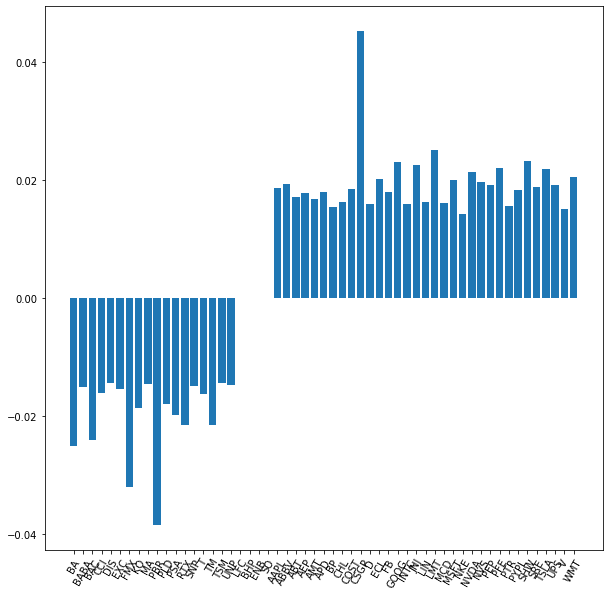

In [114]:
plt.figure(figsize=(10,10))
plt.bar(x = probs.ticker,
        height = probs.weight*probs.direction)
plt.xticks(rotation=60)
plt.show()

In [102]:
probs.prob.sum()

14.755584

In [104]:
probs.weight.sum()

1.0

In [63]:
pd.DataFrame(0, index=data.Ticker.unique(), columns=['prev_close', 'direction']).head(5)

,prev_close,direction
AAPL,0,0
ABBV,0,0
ABT,0,0
AEP,0,0
AMT,0,0


In [64]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC',
       'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR',
       'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX', 'SHW', 'SNP',
       'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
      dtype=object)

In [65]:
data[data.Ticker=='FMX']

open    high     low   close  spread_open  spread_high  \
20200501 0    65.860  65.860  61.690  62.740        13.28        14.09   
         1    63.050  63.525  63.050  63.230         3.84         3.84   
         2    63.530  63.540  63.050  63.280         2.88         3.84   
         3    63.580  63.580  63.050  63.325         2.78         3.84   
         4    63.585  63.610  63.050  63.610         2.77         3.84   
...              ...     ...     ...     ...          ...          ...   
20200529 385  67.615  67.635  67.550  67.575         0.03         0.13   
         386  67.580  67.590  67.480  67.505         0.04         0.16   
         387  67.480  67.515  67.440  67.500         0.08         0.09   
         388  67.500  67.500  67.460  67.465         0.02         0.08   
         389  67.490  68.235  66.745  66.745         0.08         2.03   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          2.97          4.46           1.0           7.0   
         1          2.89          3.48           7.0           7.0   
         2          2.86          3.38           1.0           7.0   
         3          2.78          3.29           1.0           7.0   
         4          2.72          2.72           1.0           7.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.03           1.0           7.0   
         386        0.01          0.03           1.0           7.0   
         387        0.01          0.02           7.0          13.0   
         388        0.01          0.03           1.0           8.0   
         389        0.02          2.03           1.0           8.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0            7.0           1.0           1.0   
         1            1.0            4.0           1.0           1.0   
         2            1.0            4.0           1.0           1.0   
         3            1.0            4.0           1.0           1.0   
         4            1.0            1.0           1.0           1.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           1.0          11.0   
         386          1.0            1.0           1.0          11.0   
         387          1.0            2.0           1.0          11.0   
         388          1.0            1.0           1.0          10.0   
         389          1.0            8.0          10.0          11.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            1.0    FMX  Consumer Defensive  
         1            1.0            1.0    FMX  Consumer Defensive  
         2            1.0            1.0    FMX  Consumer Defensive  
         3            1.0            1.0    FMX  Consumer Defensive  
         4            1.0            1.0    FMX  Consumer Defensive  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    FMX  Consumer Defensive  
         386          1.0            1.0    FMX  Consumer Defensive  
         387          1.0            1.0    FMX  Consumer Defensive  
         388          1.0            1.0    FMX  Consumer Defensive  
         389          1.0            9.0    FMX  Consumer Defensive  

[7800 rows x 18 columns]

In [157]:
'''
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

'''


class backtest():
    def __init__(self, X_test, data, preds, weight_scheme, max_steps, max_positions, n_classes):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'
        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes

        if verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')



    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')

        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            #print(ts_data)

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]

            self.update_positions(ts, close_info, ts_preds)

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

        #for ts in unique_timesteps[:2]:

        # for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
        #     #print(i)
        #     ts_data = data.loc[(ts[0], ts[1])]
        #     if ts_data.shape == 0:
        #         pass
        #         #print(i, 'hovhov')


    def update_positions(self, ts, close_info, ts_preds):

        #print(ts_preds, '\n')

        # use predictions to select what to hold
        long_list = ts_preds[ts_preds['class'] == (self.n_classes - 1)].index.values
        short_list = ts_preds[ts_preds['class'] == 0].index.values

        if verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # if any open positions
        # if (len(self.open_long_positions) > 0) or (len(self.open_short_positions) > 0):


        # check if any new positions are made
        new_buy = long_list[~np.isin(long_list, self.open_long_positions)]
        new_sell = short_list[~np.isin(short_list, self.open_short_positions)]




        print(self.ticker_dict)
#             self.hist_rets

        if verbose >= 1:
            print(f'new_buy: {new_buy}')
            print(f'new_sell: {new_sell} \n')

        self.open_long_positions += [long_i for long_i in new_buy]
        self.open_short_positions += [short_i for short_i in new_sell]

        self.ticker_dict

        if verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

#             print(self.open_long_positions,'\n') #[~np.isin(self.open_long_positions, long_list)])
#             print(np.isin(self.open_long_positions, long_list),'\n')
#             print(long_list,'\n')

        # check if any are closed
        close_buy = np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)]
        close_short = np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)]

        if verbose >= 1:
            print(f'close_buy: {close_buy}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_buy]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.t > 0:

            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction'] = -1
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

#             print(close_info.close.values[21])
#             print(close_info.spread_close.values[21])
#             print(self.prev_close.direction.values[21])
            print('Close prices: \n\n',close_info.close.values)
            # * self.prev_close.direction.values\
            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
#             print(self.all_tickers,'\n')
#             print(current_ret,'\n')
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_buy)
#             print(self.all_tickers[boolcousin],'\n')
#             print(close_info[boolcousin].close.values,'\n')
#             print(close_info[boolcousin].spread_close.values,'\n')
#             print(self.prev_close[boolcousin].direction.values,'\n')
#             print((close_info[boolcousin].close.values\
#                                                                  *abs(self.prev_close[boolcousin].direction.values)\
#                                                                  +(close_info[boolcousin].spread_close.values / 2)\
#                                                                  *self.prev_close[boolcousin].direction.values))
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values
#             print(current_ret)
#             print(self.prev_close.direction.values)
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
#             current_ret[current_ret == 0] = 1
            current_ret[self.prev_close.direction.values == 0] = 1

            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]

            # update total portfolio returns for open positions
#             print(current_ret)
#             print((current_ret-1)[current_ret!=0])
#             current_ret[self.prev_close.direction.values == 0] = 0

            ## if the weights should be based on the probabilities and their distribution.
#             if self.weight_scheme == 'prob_dist':

#             ## if the weights should be based on the probabilities and equally distributed between long and short positions.
#             elif self.weight_scheme == 'prob_equal':

#             else:

            self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
            
            
        
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1
            
#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
            
            print('Spread:\n\n',close_info.spread_close)
            print('Corrected Prices:\n\n',self.prev_close)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0

        else:



            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1


#             self.ticker_dict = {j:[close_info.iloc[i,0], 1, 0] if j in new_buy \
#                                 else j:[close_info.iloc[i,0], -1, 0] if j in new_sell \
#                                 else j:[close_info.iloc[i,0], 0, 0] \
#                                     for i,j in enumerate(close_info.Ticker)}

#             self.ticker_dict = {j.Ticker:[j.close, 1, 0] if j in new_buy \
#                                 else j.Ticker:[j.close, -1, 0] if j in new_sell \
#                                 else j.Ticker:[j.close, 0, 0] \
#                                     for i,j in enumerate(close_info.iterrows())}

            print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
            print(self.prev_close)

#         print(close_info.close.copy(deep=True).values)

#         self.prev_close.loc[:,'prev_close'] = close_info.close.values

#         print(close_info.close.copy(deep=True).values)

        #print(self.prev_close.loc[:,'prev_close'])


backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = None,
                        max_steps=5,
                        max_positions = 50,
                        n_classes=5)
backtest_obj.run()


initial self.open_long_positions: []
initial self.open_short_positions: [] 

['AAPL' 'ABBV' 'ABT' 'AEP' 'AMT' 'APD' 'BA' 'BABA' 'BAC' 'BHP' 'BP' 'CCI'
 'CHL' 'COST' 'CSGP' 'D' 'DIS' 'ECL' 'ENB' 'EXC' 'FB' 'FMX' 'GOOG' 'INTC'
 'JNJ' 'KO' 'LFC' 'LIN' 'LMT' 'MA' 'MCD' 'MSFT' 'NKE' 'NVDA' 'NVS' 'PBR'
 'PEP' 'PFE' 'PLD' 'PSA' 'PTR' 'PYPL' 'RTX' 'SHW' 'SNP' 'SO' 'SRE' 'T'
 'TM' 'TSLA' 'TSM' 'UNP' 'UPS' 'V' 'WMT'] 



################ Period 0 ################


long_list: ['AAPL' 'ABBV' 'ABT' 'AEP' 'AMT' 'APD' 'BP' 'CHL' 'COST' 'CSGP' 'D' 'ECL'
 'FB' 'GOOG' 'INTC' 'JNJ' 'LIN' 'LMT' 'MCD' 'MSFT' 'NKE' 'NVDA' 'NVS'
 'PEP' 'PFE' 'PTR' 'PYPL' 'SHW' 'SRE' 'TSLA' 'UPS' 'V' 'WMT']
short_list: ['BA' 'BABA' 'BAC' 'CCI' 'DIS' 'EXC' 'FMX' 'KO' 'MA' 'PBR' 'PLD' 'PSA'
 'RTX' 'SNP' 'T' 'TM' 'TSM' 'UNP'] 

{}
new_buy: ['AAPL' 'ABBV' 'ABT' 'AEP' 'AMT' 'APD' 'BP' 'CHL' 'COST' 'CSGP' 'D' 'ECL'
 'FB' 'GOOG' 'INTC' 'JNJ' 'LIN' 'LMT' 'MCD' 'MSFT' 'NKE' 'NVDA' 'NVS'
 'PEP' 'PFE' 'PTR' 'PYPL' 'SHW' 'SRE' 'TSLA' 'U

long_list: ['AAPL' 'ABT' 'AEP' 'AMT' 'CCI' 'CSGP' 'DIS' 'ENB' 'EXC' 'FMX' 'KO' 'MA'
 'MCD' 'MSFT' 'NKE' 'PEP' 'PLD' 'PSA' 'SRE' 'T' 'TM' 'TSLA' 'V']
short_list: ['APD' 'BA' 'BABA' 'BAC' 'COST' 'D' 'ECL' 'FB' 'GOOG' 'INTC' 'JNJ' 'LIN'
 'LMT' 'NVDA' 'NVS' 'PBR' 'PFE' 'PTR' 'PYPL' 'SHW' 'SNP' 'TSM' 'UNP' 'UPS'
 'WMT'] 

{}
new_buy: ['FMX' 'KO' 'MA' 'PLD' 'T' 'V']
new_sell: ['APD' 'D' 'ECL' 'GOOG' 'LIN' 'LMT' 'NVS' 'PFE' 'PTR' 'PYPL' 'SHW' 'SNP'
 'TSM' 'UNP' 'UPS' 'WMT'] 

Opening new trades, status after:
all long: ['AAPL', 'ABT', 'AEP', 'AMT', 'APD', 'CHL', 'CSGP', 'D', 'ECL', 'GOOG', 'LMT', 'MCD', 'MSFT', 'NKE', 'PEP', 'PTR', 'PYPL', 'SHW', 'SRE', 'TSLA', 'UPS', 'CCI', 'DIS', 'ENB', 'EXC', 'PSA', 'SNP', 'SO', 'TM', 'TSM', 'UNP', 'FMX', 'KO', 'MA', 'PLD', 'T', 'V']
all short: ['BA', 'BABA', 'BAC', 'FMX', 'MA', 'PBR', 'PLD', 'RTX', 'T', 'BHP', 'COST', 'FB', 'INTC', 'JNJ', 'NVDA', 'APD', 'D', 'ECL', 'GOOG', 'LIN', 'LMT', 'NVS', 'PFE', 'PTR', 'PYPL', 'SHW', 'SNP', 'TSM', 'UNP', 'UPS', 'WMT'

long_list: ['AAPL' 'ABT' 'AMT' 'APD' 'BA' 'BAC' 'BHP' 'CCI' 'D' 'FB' 'GOOG' 'JNJ'
 'KO' 'LIN' 'LMT' 'MCD' 'NVDA' 'PEP' 'PSA' 'PTR' 'PYPL' 'SHW' 'SNP' 'SRE'
 'V']
short_list: ['BABA' 'COST' 'CSGP' 'ECL' 'ENB' 'FMX' 'LFC' 'MA' 'MSFT' 'NKE' 'RTX' 'TM'
 'TSLA' 'UPS' 'WMT'] 

{}
new_buy: ['AAPL' 'BAC' 'D' 'GOOG' 'LIN' 'LMT' 'MCD' 'SHW']
new_sell: ['CSGP' 'ENB' 'FMX' 'LFC' 'MA' 'WMT'] 

Opening new trades, status after:
all long: ['ABT', 'AMT', 'CSGP', 'PEP', 'SRE', 'CCI', 'DIS', 'ENB', 'PSA', 'FMX', 'KO', 'MA', 'T', 'V', 'ABBV', 'APD', 'BA', 'BHP', 'BP', 'FB', 'JNJ', 'NVDA', 'NVS', 'PFE', 'PTR', 'PYPL', 'SNP', 'TSM', 'AAPL', 'BAC', 'D', 'GOOG', 'LIN', 'LMT', 'MCD', 'SHW']
all short: ['BABA', 'COST', 'D', 'ECL', 'GOOG', 'LIN', 'LMT', 'SHW', 'UNP', 'UPS', 'AEP', 'CHL', 'EXC', 'MCD', 'MSFT', 'NKE', 'RTX', 'TM', 'TSLA', 'CSGP', 'ENB', 'FMX', 'LFC', 'MA', 'WMT'] 

close_buy: ['CSGP' 'DIS' 'ENB' 'FMX' 'MA' 'T' 'ABBV' 'BP' 'NVS' 'PFE' 'TSM']
close_short: ['D' 'GOOG' 'LIN' 'LMT' 'SHW' 'UNP' 'AEP' '

In [158]:
backtest_obj.hist_rets

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.99768468, 0.99689208, 0.99715421, 0.99836991, 0.99640201,
        0.99793707, 0.99681947, 1.00164848, 0.99514973, 1.        ,
        0.99914493, 1.00664452, 0.99564729, 0.9989855 , 0.98558997,
        0.99744619, 0.99909

In [167]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:]

open     high      low    close
20200501 0  286.250  289.260  285.870  289.260
         1  289.260  289.350  288.365  289.020
         2  289.035  289.705  288.280  288.580
         3  288.485  289.315  288.280  289.095
         4  289.100  290.435  288.940  290.320
         5  290.320  290.440  289.520  290.085
         6  289.990  291.215  289.985  291.110
         7  291.120  291.735  290.610  291.545
         8  291.550  292.170  291.275  292.115
         9  292.095  292.960  291.590  292.580

In [168]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:].astype(str).to_csv('tabledata.csv')

In [121]:
data.sort_index().loc[(20200526,0)].reset_index().loc[21]

level_0                    20200526
level_1                           0
open                          67.16
high                         68.305
low                          67.065
close                         67.12
spread_open                    2.14
spread_high                    2.85
spread_low                     0.22
spread_close                   0.92
bidsize_open                      1
bidsize_high                      5
bidsize_low                       1
bidsize_close                     4
ofrsize_open                      1
ofrsize_high                      9
ofrsize_low                       1
ofrsize_close                     1
Ticker                          FMX
sector           Consumer Defensive
Name: 21, dtype: object

In [120]:
data.sort_index().loc[(20200526,1)].reset_index().loc[21]

level_0                    20200526
level_1                           1
open                         67.125
high                          68.65
low                          67.125
close                         68.65
spread_open                    0.93
spread_high                    1.94
spread_low                     0.08
spread_close                   0.52
bidsize_open                      4
bidsize_high                      5
bidsize_low                       1
bidsize_close                     1
ofrsize_open                      2
ofrsize_high                      5
ofrsize_low                       1
ofrsize_close                     2
Ticker                          FMX
sector           Consumer Defensive
Name: 21, dtype: object

In [169]:
data[data.Ticker=='AAPL']

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  319.255  319.415  318.830  319.095         0.11         0.17   
         386  319.095  319.295  318.810  318.845         0.05         0.22   
         387  318.845  319.605  318.695  319.460         0.03         0.11   
         388  319.465  319.555  318.660  318.675         0.05         0.12   
         389  318.675  319.380  317.500  317.920         0.03         0.22   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.05           2.0         485.0   
         386        0.01          0.03           1.0          20.0   
         387        0.01          0.06           1.0          10.0   
         388        0.01          0.03           1.0          38.0   
         389        0.01          0.04           3.0         240.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           1.0          22.0   
         386          1.0            2.0           6.0          11.0   
         387          1.0            2.0           1.0           9.0   
         388          1.0            1.0           6.0          19.0   
         389          1.0           28.0           1.0          32.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            7.0   AAPL  Technology  
         386          1.0            1.0   AAPL  Technology  
         387          1.0            6.0   AAPL  Technology  
         388          1.0            1.0   AAPL  Technology  
         389          1.0           31.0   AAPL  Technology  

[7800 rows x 18 columns]

In [54]:
[i for i in backtest_obj.hist_rets[1]]

[0.9979776148205325,
 0.9967308001500615,
 0.9984950282182209,
 1.0006905643794335,
 1.0021949254933546,
 1.0177412285278955,
 1.0016243303957144,
 1.0,
 1.0042167404596247,
 1.0,
 1.0,
 1.004122423485322,
 1.0,
 0.9991814282439999,
 1.006763702456684,
 0.9992085235920856,
 1.0,
 0.9991660125588697,
 1.0,
 1.0029054410987848,
 0.997180686659427,
 1.0305423122765196,
 1.0007589525062839,
 0.9974074946971483,
 0.9939279588336195,
 1.0022481533026442,
 1.0,
 0.999561776609182,
 0.9983624018106775,
 1.0,
 0.9971667672289408,
 0.9976855589644223,
 1.0,
 0.99685371125277,
 0.9984766815092572,
 1.0012995451591942,
 0.9990513774000154,
 0.9956360751124042,
 1.0054239539517378,
 1.0134100117631681,
 1.0,
 0.998111733298607,
 0.9987213298169904,
 1.0070498123771001,
 1.0189236490921025,
 1.0,
 0.9984570953831546,
 1.0017897819720143,
 1.0,
 0.9997049472517945,
 1.0,
 1.0036002006669222,
 1.0015313153999286,
 1.0,
 0.9977233694132683,
 1.0816254175898783]

In [46]:
backtest_obj.prev_close

,prev_close,direction
AAPL,323.180,0
ABBV,93.050,0
ABT,92.855,0
AEP,79.620,1
AMT,247.855,1
APD,239.455,1
BA,145.090,-1
BABA,205.910,-1
BAC,23.825,0
BHP,46.590,-1


In [71]:
data.sort_index()

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         0     81.000   82.110   80.580   81.010         2.00         2.06   
         0     91.025   91.435   90.490   91.220         1.89         1.89   
         0     83.455   83.980   82.250   82.470         3.09         4.14   
         0    234.350  234.575  232.215  232.950         3.30         3.87   
...               ...      ...      ...      ...          ...          ...   
20200529 389   50.455   50.495   50.325   50.325         0.01         0.05   
         389  169.960  170.030  169.610  169.675         0.04         0.36   
         389  100.095  100.110   99.670   99.670         0.05         0.13   
         389  195.855  195.920  194.195  194.195         0.03         2.39   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         0          0.01          0.24          12.0          12.0   
         0          0.03          0.24           1.0           5.0   
         0          0.10          0.14           1.0           7.0   
         0          0.27          2.90           1.0           3.0   
...                  ...           ...           ...           ...   
20200529 389        0.01          0.05           5.0          38.0   
         389        0.01          0.23          10.0          11.0   
         389        0.01          0.12           1.0          11.0   
         389        0.01          2.39           2.0           7.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         0            1.0            1.0           1.0           9.0   
         0            1.0            1.0           1.0           5.0   
         0            1.0            1.0           7.0           8.0   
         0            1.0            1.0           2.0           3.0   
...                   ...            ...           ...           ...   
20200529 389          1.0            2.0           7.0          24.0   
         389          1.0            1.0           1.0          10.0   
         389          1.0            7.0           1.0          11.0   
         389          1.0            1.0           1.0           9.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         0            1.0            1.0   ABBV          Healthcare  
         0            1.0            1.0    ABT          Healthcare  
         0            1.0            1.0    AEP           Utilities  
         0            1.0            1.0    AMT         Real Estate  
...                   ...            ...    ...                 ...  
20200529 389          1.0            9.0    TSM          Technology  
         389          1.0            2.0    UNP         Industrials  
         389          1.0            1.0    UPS         Industrials  
         389          1.0            2.0      V  Financial Services  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [63]:
print("Keras version:", keras.__version__)

Keras version: 2.3.0-tf


In [64]:
preds

0         1         2  class
days     timestamps ticker                                     
20200526 0          AAPL    0.416253  0.368611  0.215136      0
                    ABBV    0.329215  0.408036  0.262749      1
                    ABT     0.186563  0.231664  0.581773      2
                    AEP     0.148577  0.133585  0.717838      2
                    AMT     0.513806  0.248181  0.238014      0
...                              ...       ...       ...    ...
20200529 387        TSM     0.129696  0.530026  0.340278      1
                    UNP     0.395135  0.284087  0.320778      0
                    UPS     0.222739  0.542764  0.234497      1
                    V       0.276288  0.431778  0.291934      1
                    WMT     0.195635  0.483837  0.320528      1

[85690 rows x 4 columns]

In [52]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [176]:
ts_preds = preds.loc[(20200526, 0)]
ts_preds[ts_preds['class'] == 1].index.values

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BABA', 'BHP', 'BP',
       'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL', 'ENB', 'EXC',
       'FB', 'GOOG', 'INTC', 'JNJ', 'LFC', 'LIN', 'LMT', 'MA', 'MCD',
       'MSFT', 'NKE', 'NVDA', 'NVS', 'PEP', 'PFE', 'PLD', 'PTR', 'PYPL',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TSLA', 'TSM', 'UNP', 'UPS', 'V',
       'WMT'], dtype=object)

In [208]:
long_list = ts_preds[ts_preds['class'] == 1].index.values
short_list = ts_preds[ts_preds['class'] == 0].index.values

print(long_list, short_list,'\n\n')

open_long_positions = ['AAPL','ABT']
open_short_positions = ['BAC','KO']

# check if any new positions are made
# if any open positions
if (len(open_long_positions) > 0) or (len(open_short_positions) > 0):
    new_buy = long_list[~np.isin(long_list, open_long_positions)]
    new_short = short_list[~np.isin(short_list, open_short_positions)] 
    
new_buy, new_short

['AAPL' 'ABBV' 'ABT' 'AEP' 'AMT' 'APD' 'BABA' 'BHP' 'BP' 'CCI' 'CHL'
 'COST' 'CSGP' 'D' 'DIS' 'ECL' 'ENB' 'EXC' 'FB' 'GOOG' 'INTC' 'JNJ' 'LFC'
 'LIN' 'LMT' 'MA' 'MCD' 'MSFT' 'NKE' 'NVDA' 'NVS' 'PEP' 'PFE' 'PLD' 'PTR'
 'PYPL' 'SHW' 'SNP' 'SO' 'SRE' 'T' 'TSLA' 'TSM' 'UNP' 'UPS' 'V' 'WMT'] ['BA' 'BAC' 'FMX' 'KO' 'PBR' 'PSA' 'RTX' 'TM'] 




(array(['ABBV', 'AEP', 'AMT', 'APD', 'BABA', 'BHP', 'BP', 'CCI', 'CHL',
        'COST', 'CSGP', 'D', 'DIS', 'ECL', 'ENB', 'EXC', 'FB', 'GOOG',
        'INTC', 'JNJ', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE',
        'NVDA', 'NVS', 'PEP', 'PFE', 'PLD', 'PTR', 'PYPL', 'SHW', 'SNP',
        'SO', 'SRE', 'T', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
       dtype=object),
 array(['BA', 'FMX', 'PBR', 'PSA', 'RTX', 'TM'], dtype=object))

In [209]:
open_long_positions[int(~np.isin(open_long_positions, long_list))]

TypeError: only size-1 arrays can be converted to Python scalars

In [211]:
~np.isin(open_long_positions, long_list)

array([False, False])

In [215]:
# check if any are closed
close_buy = open_long_positions[~np.isin(open_long_positions, long_list)] 
close_short = open_short_positions[~np.isin(open_short_positions, short_list)] 

TypeError: only integer scalar arrays can be converted to a scalar index

In [191]:
np.isin(long_list, open_long_positions, invert=True)

array([], dtype=bool)

In [158]:
for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
    #print(i)
    ts_data = data.loc[(ts[0], ts[1])]
    if ts_data.shape == 0:
        pass

C:\Users\fstri\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [162]:
ts_data[['close','spread_close']]

20200526  1     323.220
          1      93.110
          1      92.885
          1      79.700
          1     248.845
          1     243.805
          1     145.270
          1     206.010
          1      23.835
          1      46.610
          1      23.385
          1     160.760
          1      35.665
          1     305.560
          1     675.770
          1      82.060
          1     121.575
          1     203.670
          1      32.245
          1      37.970
          1     238.925
          1      69.170
          1    1437.280
          1      63.520
          1     145.605
          1      46.810
          1       9.430
          1     194.000
          1     374.935
          1     303.180
          1     190.055
          1     185.360
          1      96.175
          1     364.760
          1      85.290
          1       7.725
          1     131.645
          1      37.665
          1      90.830
          1     193.840
          1      34.395
          1     

In [128]:
#tmp = [(i,j) for i,j in zip(X_test.index.get_level_values(0),X_test.index.get_level_values(1))]

X_test.reset_index().groupby(['days','timestamps']).size()


#np.unique(X_test.index.get_level_values(1))

days      timestamps
20200526  0             55
          1             55
          2             55
          3             55
          4             55
                        ..
20200529  383           55
          384           55
          385           55
          386           55
          387           55
Length: 1558, dtype: int64

In [155]:
# 20200526  0
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [132]:
np.unique(X_test.index.get_level_values(1))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [134]:
hej = np.concatenate([[[i,j] for i in np.unique(X_test.index.get_level_values(1))] \
                              for j in np.unique(X_test.index.get_level_values(0))])
hej

array([[       0, 20200526],
       [       1, 20200526],
       [       2, 20200526],
       ...,
       [     387, 20200529],
       [     388, 20200529],
       [     389, 20200529]], dtype=int64)

In [152]:
def t1():
    for i in hej[:]:
        #print(i)
        try:
            timestep_data = X_test.loc[(i[1], i[0])]
        except:
            pass
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [153]:
def t2():
    for i in X_test.reset_index().groupby(['days','timestamps']).size().index[:]:
        #print(i)
        timestep_data = X_test.loc[(i[0], i[1])]
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [154]:
%timeit t1()
%timeit t2()

470 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
505 ms ± 6.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [137]:
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [106]:
np.unique(( X_test.index.get_level_values(0).values, X_test.index.get_level_values(1).values ))

array([       0,        1,        2,        3,        4,        5,
              6,        7,        8,        9,       10,       11,
             12,       13,       14,       15,       16,       17,
             18,       19,       20,       21,       22,       23,
             24,       25,       26,       27,       28,       29,
             30,       31,       32,       33,       34,       35,
             36,       37,       38,       39,       40,       41,
             42,       43,       44,       45,       46,       47,
             48,       49,       50,       51,       52,       53,
             54,       55,       56,       57,       58,       59,
             60,       61,       62,       63,       64,       65,
             66,       67,       68,       69,       70,       71,
             72,       73,       74,       75,       76,       77,
             78,       79,       80,       81,       82,       83,
             84,       85,       86,       87,       88,      